In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import operator
import datetime
import matplotlib.pyplot as plt

In [2]:
import scipy.stats
import copy
import datetime 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import  StandardScaler
from sklearn.decomposition import PCA
import xgboost as xg
import os
import pathlib

c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
import sys
sys.path.insert(1, 'D:/TMU/thesis/codes')

from package.featureSelection_SICE import *
from package.loadDb import *

In [4]:
# import kaggle dataset
address = "..\..\..\database\kaggleDataFrame"

data_with_target= load_kaggle_dataframe(address+"\dataframes.csv")
data_without_target = data_with_target.drop(['DEMAND'],axis=1)
print("data with target size = ",data_with_target.shape )

# # make kaggle PCA dataset
# pca = PCA(n_components=num_comp).fit(data_without_target)
# columns = ['pca_comp_%i' % i for i in range(num_comp)]
# data_pca  = pd.DataFrame(pca.transform(data_without_target), columns=columns, index=data_without_target.index)
# # data_pca.head()

# ...................................................................................................

# # import sock market dataset 
# sample_normalized = load_stock_market_dataframe(address+"\sample_normalized")
# data_with_target = load_stock_market_dataframe(address+"\sample_normalized_with_target")
# data_without_target = data_with_target.iloc[:,:-1]
# # import sock market PCA dataset 

# data_pca=load_stock_market_dataframe(address+"\data_pca_13_with_target")
# data_pca=data_pca[:,:-1]


data with target size =  (46968, 11)


In [5]:

number_components=4
window_size=2000


In [6]:
def featureSelection_svd(data_without_target,window_size,num_comp):

    win_index_dic,num_windows = window_moving(data_without_target,window_size)
    feature_similarity_tensor=cosine_sim(data_without_target,win_index_dic,num_windows)
    H= H_matrix(feature_similarity_tensor)
    u, _, _ = np.linalg.svd(H, full_matrices=True)
    R=H-np.dot(u.T,H)
    x = np.linalg.norm(R, axis=0)
    top_ranked_pairs=len(x) # keep all pairs

    selected_features_index=Pr_to_feature(x,num_components=num_comp,top_pairs=top_ranked_pairs)
    return selected_features_index



In [7]:
def mse_xgboost_segment(data_without_target,target,window_size,num_comp,interval_,testSize):

    '''
    this functiont segment data to a given intervals and make list of RMSE for pca and new model
    '''

    pca_list=[]
    fselection_list = []

    interval=interval_
    start=0
    end=interval

    while data_without_target.shape[0] > end:

        X=data_without_target.iloc[start : end]
        Y=target.iloc[start : end]

        
        pca = PCA(n_components=num_comp).fit(X)
        X_pca  = pca.transform(X)
        # data_pca.head()



        selected_features_index=featureSelection_svd(X,window_size,num_comp)


        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = testSize,shuffle=False)
        x_train_pca, x_test_pca, _,_ = train_test_split(X_pca, Y, test_size = testSize,shuffle=False)


        # fit pca data
        model_pca = xg.XGBRegressor()
        model_pca.fit(x_train_pca, y_train)
        predictions_pca = model_pca.predict(x_test_pca)
        rmse_pca=np.sqrt(metrics.mean_squared_error(y_test, predictions_pca))
        # print("MSE of pca is:{:.2f}".format(pca_mse))
        pca_list.append(rmse_pca)##########################


        x_train_PR= x_train[x_train.columns[selected_features_index]]
        x_test_PR = x_test[x_test.columns[selected_features_index]]

        # fit model data
        model_fselection = xg.XGBRegressor()
        model_fselection.fit(x_train_PR, y_train)
        predictions_fselection = model_fselection.predict(x_test_PR)
        rmse_fselection=np.sqrt(metrics.mean_squared_error(y_test, predictions_fselection))
        # print ("MSE model is:{:.2f}".format( mse))
        fselection_list.append(rmse_fselection)

        start=start + interval
        end=end + interval 
         
    print ("RMSE of f_s model is",np.array(fselection_list).round( decimals=2))
    print ("RMSE of pca model is",np.array(pca_list).round( decimals=2))
    
    return fselection_list,pca_list

number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


number of windows= 40 
size of windows = 50 10 
last window size = 50 10
size of similarity tensor = (10, 10, 40)
size of second order similarity matrix = (100, 100)


c:\Users\User.MORADI-PC\anaconda3\envs\tf\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE of f_s model is [ 89.86  88.5   59.66  89.23 104.63  89.66  54.56  79.89  53.82 101.75
  55.52  58.05 108.58 122.87  51.67  53.13  70.56  98.81 103.3   72.14
  92.27 129.03  72.29]
RMSE of pca model is [ 95.65  93.97  66.15  90.19  79.83  61.69  57.48  91.47  71.24 100.2
  63.21  67.69 120.98 117.76  64.74  65.84  68.94 115.99 103.93  75.85
 100.95 128.51  63.19]


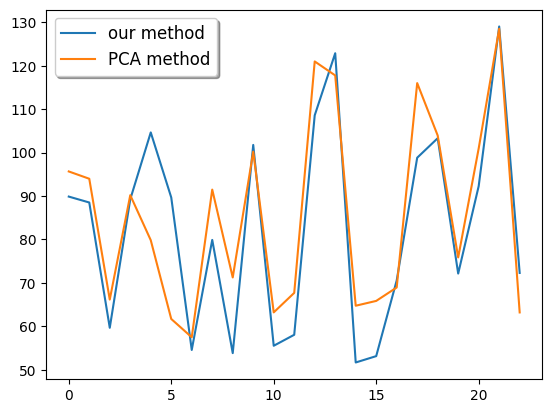

In [8]:
window_size=50 #depends on the number of records
num_comp = 4
interval_ = 2000
testSize=500
method_list,pca_list=mse_xgboost_segment(data_without_target,data_with_target.iloc[:,10],window_size,num_comp,interval_,testSize)

t = np.arange(len(method_list))
t.shape
fig, ax = plt.subplots()
ax.plot(t,method_list, label='our method')

# Plot another line on the same chart/graph
ax.plot(t, pca_list, label='PCA method')
legend = ax.legend(loc='upper left', shadow=True, fontsize='large')
plt.show()